<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/dem_variational_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import os
import time
from scipy.io import readsav
import numpy as np
import glob
import tensorflow as tf
import tensorflow
tensorflow.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2,l1

import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import pickle

from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import glob
import tensorflow_addons as tfa

from astropy.io import fits

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
##Defining the kernel matrix ranging from temp bins logT=5.5-7.2
trin = readsav('/content/drive/MyDrive/nikita/aia_tresp_en.dat')
logt = np.linspace(5.5,7.2,18)
k_matrix = trin['tr'][:,[30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64]]
kernel = np.expand_dims(np.expand_dims(np.transpose(k_matrix),axis=0),axis=0)


##Scaling the images & DEMs
def em_scale(y):
    return np.sqrt(y / 1e25)


def em_unscale(y):
    return 1e25 * (y * y)


def img_scale(x):
    x2 = x
    bad = np.where(x2 <= 0.0)
    x2[bad] = 0.0

    return np.sqrt(x2)

def img_unscale(x):
    return x * x



In [5]:
##Model Architecture

class MonteCarloDropout(layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)


def bayes_model_two():

    kwargs1 = {'kernel_size': 3, 'kernel_regularizer': l2(1e-5)}
    kwargs2 = {'kernel_size': 1, 'kernel_regularizer': l2(1e-5)}

    input_layer = layers.Input((512,512,6))
    ##This layer is only used while training
    ##It replaces all output pixels that correspond to a zero/undefined DEM with zeroes
    mask_layer = layers.Input((512,512,18))

    conv1 = layers.Conv2D(128, **kwargs2, activation = keras.layers.LeakyReLU(alpha=0.1))(input_layer)

    mc1 = MonteCarloDropout(0.5)(conv1)

    ##Transpose conv layer used for upscaling the convolved images for comparing with the original
    convT = layers.Conv2DTranspose(64, kernel_size = 3, activation = keras.layers.LeakyReLU(alpha=0.1))(mc1)

    output_dem_test = layers.Conv2D(18, **kwargs1, activation = 'relu', name = 'output_dem_test')(convT)

    ##Output 1: The DEMs with the mask layer applied
    output_dem = tf.keras.layers.multiply([output_dem_test, mask_layer], name='output_dem')

    lmbda = layers.Lambda(lambda x: tf.nn.conv2d(em_unscale(x), kernel, strides=[1,1,1,1], padding='SAME'))(output_dem_test)

    ##Output 2: The synthetic AIA images regenerated from output DEMs and kernel matrix
    output_img = layers.Lambda(lambda x: tf.sqrt(x), name='output_img')(lmbda)

    ##Defining the models
    train_model = Model(inputs=[input_layer,mask_layer], outputs={'output_dem':output_dem,'output_img':output_img})
    test_model = Model(inputs=input_layer, outputs={'output_dem':output_dem_test,'output_img':output_img})

    return train_model,test_model

train_model,test_model = bayes_model_two()


##Loading the weights for testing
test_model.load_weights('/content/drive/MyDrive/nikita/dem_variational_dropout.h5')

In [6]:
# import data
def get_data(date):
  '''
  Loads data and arranges
  '''
  file_paths = glob.glob('/content/drive/MyDrive/sdo_cor_hole_data/{}/*prep*'.format(date))

  dat = []
  wave = []
  index = []
  for files in file_paths[:6]:
    with fits.open(files) as hdul:
      dat.append(hdul[0].data)
      wave.append(hdul[0].header['wavelnth'])
    index.append(hdul[0].header)

  dat = np.array(dat)
  dat = dat[np.argsort(wave)]
  index = [index[i] for i in np.argsort(wave)]

  return dat, index

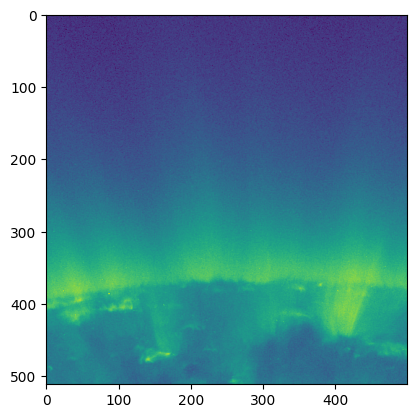

In [7]:
dat, index = get_data('2017-05-23')
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [8]:
#test image shape should be (1,512,512,6)
test_img = dat[:,  88:600, 1738:2250].T



In [9]:
def run_dem_calc(test_img):
  test_img_scaled = img_scale(test_img[np.newaxis])
  ##Generating the DEMs and synthetic images
  ##Model gives a dictionary with two outputs: 'output_dem' and 'output_img'
  output = test_model.predict(test_img_scaled)
  output_dem = output['output_dem']
  output_img = output['output_img']

  ##For unscaled output:
  output_dem_unscaled = em_unscale(output_dem)
  output_img_unscaled = img_unscale(output_img)

  return output_dem_unscaled, output_img_unscaled

In [10]:
from scipy import constants
from scipy.integrate import quad
##Creating avg DEM/temp maps

def temp_est(file):

    ##Log temp bins
    log_Te = np.linspace(5.5,7.2,18)

    em_T=0
    for i, Te in enumerate(log_Te):
        em_T = em_T + 10**Te*file[0,:,:,i]

    temp = em_T/file[0,:,:,:].sum(axis=2)

    return temp

def log_temp_est(file):

    ##Log temp bins
    log_Te = np.linspace(5.5,7.2,18)

    em_T=0
    for i, Te in enumerate(log_Te):
        em_T = em_T + Te*file[0,:,:,i]

    log_temp = em_T/file[0,:,:,:].sum(axis=2)

    return log_temp

def calc_hr(index):
    '''
    ;Calculate array of radial values.

    ;Parameters
    ;-----------
    ;nx - int
    ;     number of elements in a particular dimension
    ;ny - int
    ;     number of elements in a particular dimension

    ;Returns
    ;-------
    ;ndarray of shape (nx,ny)
    '''
    nx = index['naxis1']
    ny = index['naxis2']

    r_sun_ref = 695658. # km
    pix_scale = index['cdelt1']
    r_sun_obs = index['rsun_obs']
    dx = r_sun_ref*pix_scale/r_sun_obs #km

    cen_x = index['crpix1']
    cen_y = index['crpix2']

    x = np.tile(np.arange(nx) - (nx / 2.) + 0.5, (ny,1))*dx
    y = np.tile(np.arange(ny) - (ny / 2.) + 0.5, (nx,1))*dx
    r = (x**2 + y.T**2)**0.5

    return r



def dem_dens_bp(dem_cube, h_r):
  '''
        ; Calculates electron density from emission measure
        ;
        ; h_r  - distance from sun centre in cm
        ;
        ;
  '''

  # calculate scale height
  temp = log_temp_est(dem_cube)
  import astropy.units as u
  import astropy.constants as const
  solar_g = 2.74e4*u.cm/u.s**2  #cm/s^2
  mu = 1.27
  m_p = const.m_p #proton mass in kg
  dh = 2*const.k_B*(10**temp)*u.K/(solar_g*mu*m_p)
  dh = dh.decompose().to('cm').value

  dem = dem_cube[0].sum(axis=2)

  #h_sq = 2*h_r**2 + 2*h_r*dh + dh**2

  # Calculation of z_eff following Aschwanden
  def integrand(x, hpr, dh):
    r_sun_cm = 695658.*1e5
    return np.exp(-2*r_sun_cm/dh*(np.sqrt((hpr/r_sun_cm)**2+x**2)-1))

  z_eff = []
  for hpr, d_h in zip(h_r.ravel(), dh.ravel()):
    if hpr > 1:
      integ = quad(integrand, -np.inf, np.inf, args=(hpr, d_h))[0]
    else:
      integ = 0

    z_eff.append(integ)

  z_eff = np.array(z_eff).reshape(512,512)
  n_e = (dem/z_eff)**0.5

  return n_e, z_eff


In [11]:
def cranmer_den(x):
  return 1.3e5*(1/x**2+25/x**4+300/x**8+1500/x**16+5796/x**33.9)


In [12]:
def get_averages(hr, temp, n_e, em_cube):
    ne_avg = []
    ne_std = []
    em_avg = []
    t_avg = []
    for i, r in enumerate(rad_bins[:-1]):
        ind = np.where((hr>r) & (hr<rad_bins[i+1]))
        ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
        ne_std.append(np.nanstd(n_e[ind[0],ind[1]])/len(ind[0])**0.5)
        em_avg.append(em_cube[:,ind[0],ind[1]])
        t_avg.append(np.nanmean(temp[ind[0],ind[1]]))

    return ne_avg, ne_std, t_avg, em_avg

rad_bins = np.arange(1,1.3,0.001)

r_sun_ref = 695658.

In [13]:
output_dem_unscaled_2017, output_img_unscaled = run_dem_calc(test_img)
temp_map_2017 = log_temp_est(output_dem_unscaled_2017)
hr_2017 = calc_hr(index[0])

dens_2017 = np.sqrt(output_dem_unscaled_2017[0].sum(axis=2))

ne_avg_2017, ne_std_2017, t_avg_2017, em_avg_2017 = get_averages(hr_2017[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2017,
                                                                 dens_2017,
                                                                 output_dem_unscaled_2017)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


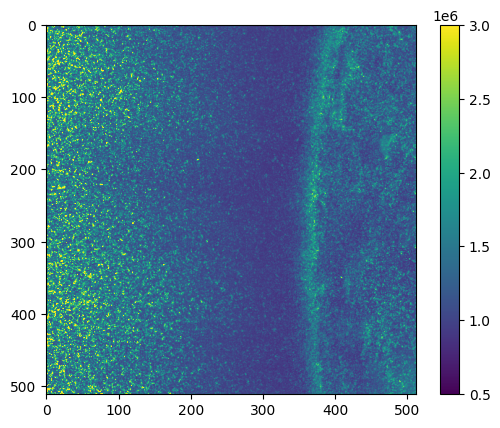

In [14]:
plt.imshow(10**temp_map_2017, vmin=0.5e6, vmax=3e6)
plt.colorbar()

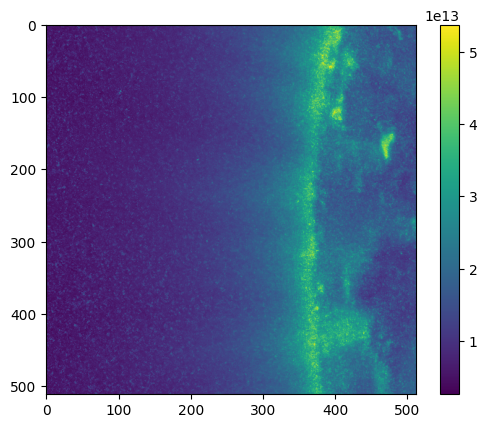

In [15]:
plt.imshow(dens_2017)
plt.colorbar()

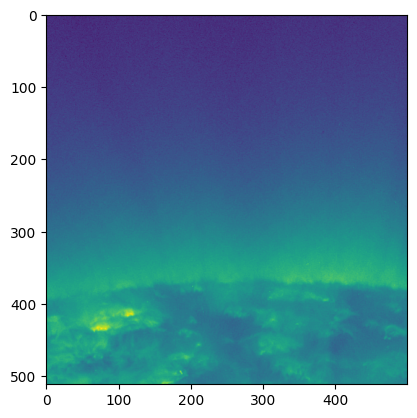

In [16]:
date = '2010-05-23'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [17]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2010, output_img_unscaled = run_dem_calc(test_img)
temp_map_2010 = log_temp_est(output_dem_unscaled_2010)
hr_2010 = calc_hr(index[0])

dens_2010 = np.sqrt(output_dem_unscaled_2010[0].sum(axis=2))

ne_avg_2010, ne_std_2010, t_avg_2010, em_avg_2010 = get_averages(hr_2010[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2010,
                                                                 dens_2010,
                                                                 output_dem_unscaled_2010)

1/1 [==============================] - 3s 3s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


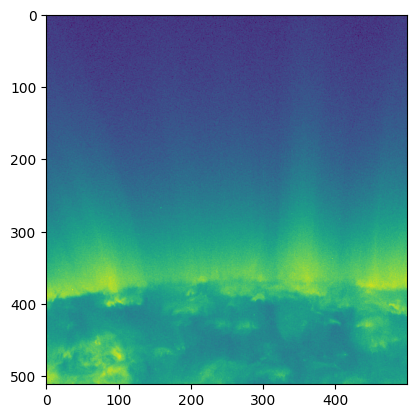

In [18]:
date = '2011-05-23'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [19]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2011, output_img_unscaled = run_dem_calc(test_img)
temp_map_2011 = log_temp_est(output_dem_unscaled_2011)
hr_2011 = calc_hr(index[0])

dens_2011 = np.sqrt(output_dem_unscaled_2011[0].sum(axis=2))
ne_avg_2011, ne_std_2011, t_avg_2011, em_avg_2011 = get_averages(hr_2011[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2011,
                                                                 dens_2011,
                                                                 output_dem_unscaled_2011)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


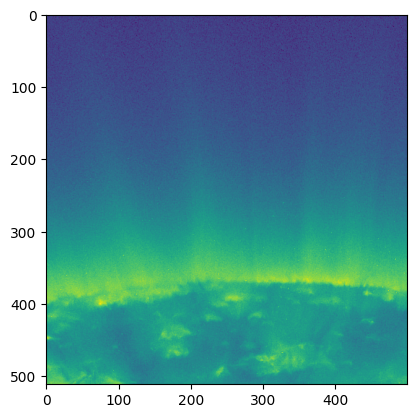

In [20]:
date = '2012-05-27'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [21]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2012, output_img_unscaled = run_dem_calc(test_img)
temp_map_2012 = log_temp_est(output_dem_unscaled_2012)
hr_2012 = calc_hr(index[0])

dens_2012 = np.sqrt(output_dem_unscaled_2012[0].sum(axis=2))
ne_avg_2012, ne_std_2012, t_avg_2012, em_avg_2012 = get_averages(hr_2012[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2012,
                                                                 dens_2012,
                                                                 output_dem_unscaled_2012)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


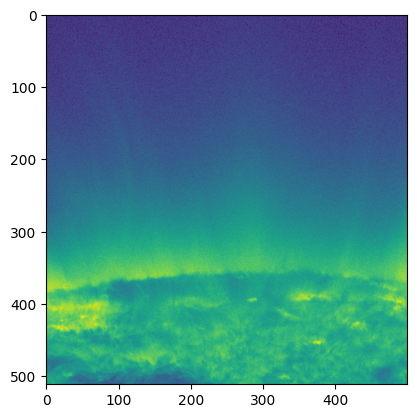

In [22]:
date = '2013-04-24'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [23]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2013, output_img_unscaled = run_dem_calc(test_img)
temp_map_2013 = log_temp_est(output_dem_unscaled_2013)
hr_2013 = calc_hr(index[0])

dens_2013 = np.sqrt(output_dem_unscaled_2013[0].sum(axis=2))
ne_avg_2013, ne_std_2013, t_avg_2013, em_avg_2013 = get_averages(hr_2013[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2013,
                                                                 dens_2013,
                                                                 output_dem_unscaled_2013)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


In [24]:
date = '2014-05-01'
dat, index = get_data(date)


NameError: name 'hr_2014' is not defined

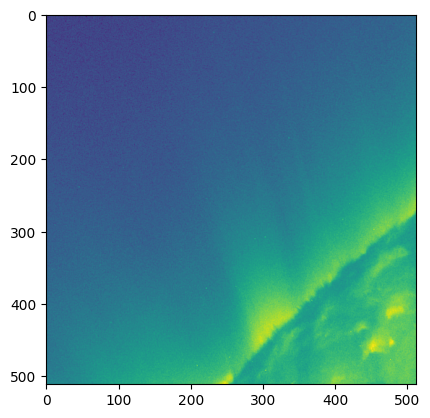

In [25]:
plt.imshow(dat[3,  488:1000,588:1100]**0.4)
plt.contour(hr_2014[488:1000,588:1100], levels=[r_sun_ref+0.01*r_sun_ref])

In [26]:
test_img = dat[:,  488:1000,588:1100].T
output_dem_unscaled_2014, output_img_unscaled = run_dem_calc(test_img)
temp_map_2014 = log_temp_est(output_dem_unscaled_2014)
hr_2014 = calc_hr(index[0])

dens_2014 = np.sqrt(output_dem_unscaled_2014[0].sum(axis=2))
ne_avg_2014, ne_std_2014, t_avg_2014, em_avg_2014 = get_averages(hr_2014[488:1000,588:1100].T/r_sun_ref,
                                                                 temp_map_2014,
                                                                 dens_2014,
                                                                 output_dem_unscaled_2014)

1/1 [==============================] - 3s 3s/step


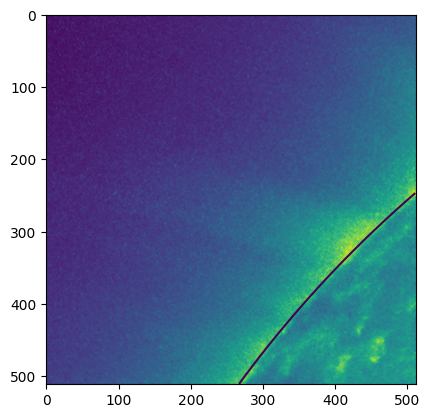

In [27]:
plt.imshow(dens_2014)
plt.contour(hr_2014[488:1000,588:1100].T, levels=[r_sun_ref+0.01*r_sun_ref])

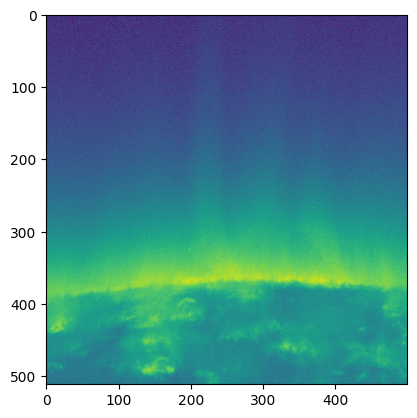

In [28]:
date = '2015-05-23'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [29]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2015, output_img_unscaled = run_dem_calc(test_img)
temp_map_2015 = log_temp_est(output_dem_unscaled_2015)
hr_2015 = calc_hr(index[0])

dens_2015 = np.sqrt(output_dem_unscaled_2015[0].sum(axis=2))
ne_avg_2015, ne_std_2015, t_avg_2015, em_avg_2015 = get_averages(hr_2015[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2015,
                                                                 dens_2015,
                                                                 output_dem_unscaled_2015)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


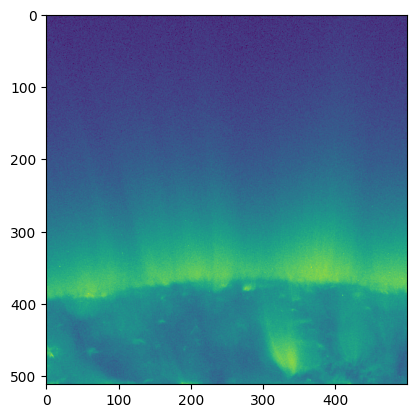

In [30]:
date = '2016-05-23'
dat, index = get_data(date)
plt.imshow(dat[2,  88:600, 1750:2250]**0.4)

In [31]:
test_img = dat[:,  88:600, 1738:2250].T
output_dem_unscaled_2016, output_img_unscaled = run_dem_calc(test_img)
temp_map_2016 = log_temp_est(output_dem_unscaled_2016)
hr_2016 = calc_hr(index[0])

dens_2016 = np.sqrt(output_dem_unscaled_2016[0].sum(axis=2))
ne_avg_2016, ne_std_2016, t_avg_2016, em_avg_2016 = get_averages(hr_2016[88:600, 1738:2250].T/r_sun_ref,
                                                                 temp_map_2016,
                                                                 dens_2016,
                                                                 output_dem_unscaled_2016)

1/1 [==============================] - 2s 2s/step


<ipython-input-12-28ed5b40ed19>:8: RuntimeWarning: Mean of empty slice
  ne_avg.append(np.nanmean(n_e[ind[0],ind[1]]))
<ipython-input-12-28ed5b40ed19>:11: RuntimeWarning: Mean of empty slice
  t_avg.append(np.nanmean(temp[ind[0],ind[1]]))


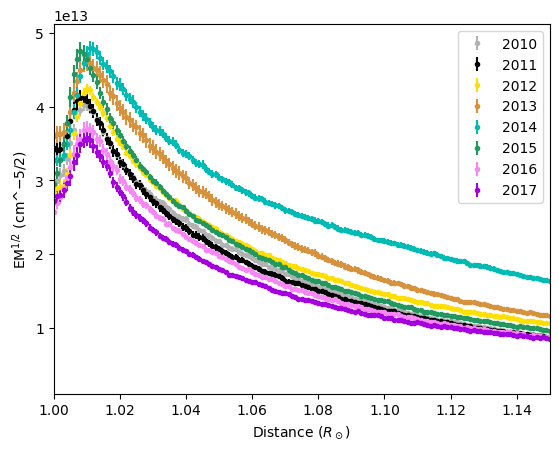

In [33]:
plt.errorbar(rad_bins[:-1], ne_avg_2010, 5.*np.array(ne_std_2010), fmt='.', label='2010', color='#B2B2B2')
plt.errorbar(rad_bins[:-1], ne_avg_2011, 5.*np.array(ne_std_2011), fmt='.', label='2011', color='black')
plt.errorbar(rad_bins[:-1], ne_avg_2012, 5.*np.array(ne_std_2012), fmt='.', label='2012', color='#FFDF00')
plt.errorbar(rad_bins[:-1], ne_avg_2013, 5.*np.array(ne_std_2013), fmt='.', label='2013', color='#D6923C')
plt.errorbar(rad_bins[:-1], ne_avg_2014, 5.*np.array(ne_std_2014), fmt='.', label='2014', color='#00BBB4')
plt.errorbar(rad_bins[:-1], ne_avg_2015, 5.*np.array(ne_std_2015), fmt='.', label='2015', color='#22975F')
plt.errorbar(rad_bins[:-1], ne_avg_2016, 5.*np.array(ne_std_2015), fmt='.', label='2016', color='#F687F4')
plt.errorbar(rad_bins[:-1], ne_avg_2017, 5.*np.array(ne_std_2015), fmt='.', label='2017', color='#A400DE')

plt.ylabel('EM$^{1/2}$ (cm^${-5/2}$)')
plt.xlabel('Distance ($R_\odot$)')
plt.xlim(1,1.15)
plt.legend()
plt.savefig('/content/drive/MyDrive/sdo_cor_hole_data/dens_cor_hole.png', dpi=300)

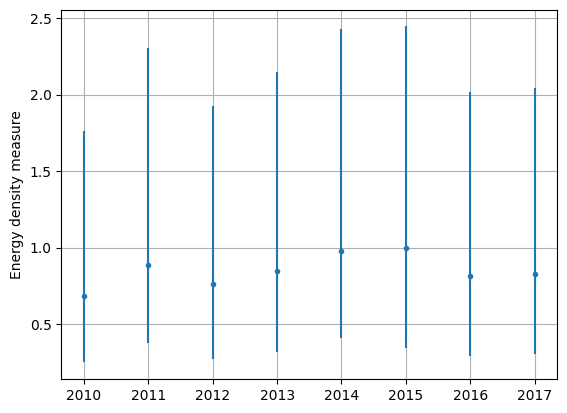

In [ ]:
# wave velocity amplitudes at 5 Mm
med = [7.3, 9.2, 8.1, 8.5, 10, 9.7, 9.1, 9.5]
iqr_25 = [4.648, 5.28, 5.176, 5.28, 5.821, 6.361, 5.821,  6.048]
iqr_75 = [11.433, 14.678, 12.413, 13.053, 14.894, 14.023, 13.484, 13.92]

all_ne = [ne_avg_2010[7], ne_avg_2011[7], ne_avg_2012[7], ne_avg_2013[7], ne_avg_2014[7], ne_avg_2015[7],
        ne_avg_2016[7], ne_avg_2017[7]]

dates = [2010,2011,2012,2013,2014,2015,2016,2017]

med_vals = [m**0.5*n for m,n in zip(all_ne,med)]
iqr25_vals = [m**0.5*n for m,n in zip(all_ne,iqr_25)]
iqr75_vals = [m**0.5*n for m,n in zip(all_ne,iqr_75)]

plt.errorbar(dates, med_vals/np.max(med_vals), yerr=[iqr25_vals/np.max(med_vals), iqr75_vals/np.max(med_vals)], fmt='.')
plt.ylabel('Energy flux measure')
plt.grid()

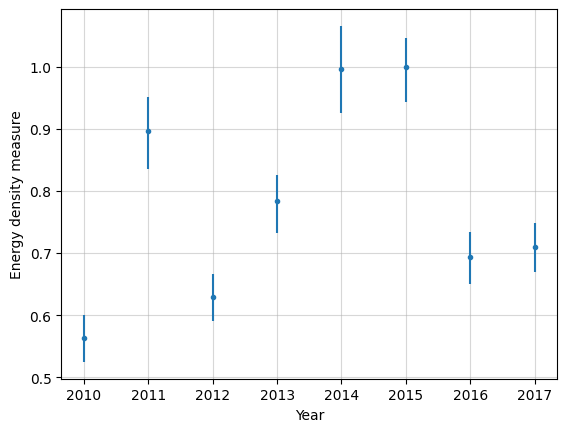

In [ ]:
v_low=[8.4892, 10.4283, 9.0108, 9.4672, 10.8684, 10.3792, 9.9393, 10.3142]
v_mean = [8.7999, 10.8034, 9.3048, 9.793, 11.2755, 10.6894, 10.265, 10.6232]
v_high = [9.0766, 11.1289, 9.5646, 10.0536, 11.666, 10.9332, 10.5584, 10.9175]

mean_vals = [m*n**2 for m,n in zip(all_ne,v_mean)]
low_vals = [m*n**2 for m,n in zip(all_ne,v_low)]
high_vals = [m*n**2 for m,n in zip(all_ne,v_high)]

low_vals = [m-n for m,n in zip(mean_vals, low_vals)]
high_vals = [m-n for m,n in zip(high_vals,mean_vals)]

plt.errorbar(dates, mean_vals/np.max(mean_vals), yerr=[low_vals/np.max(mean_vals), high_vals/np.max(mean_vals)], fmt='.')
plt.ylabel('Energy density measure')
plt.xlabel("Year")
plt.grid(alpha=0.5)
plt.savefig('/content/drive/MyDrive/sdo_cor_hole_data/wave_flux_cor_hole.png', dpi=300)

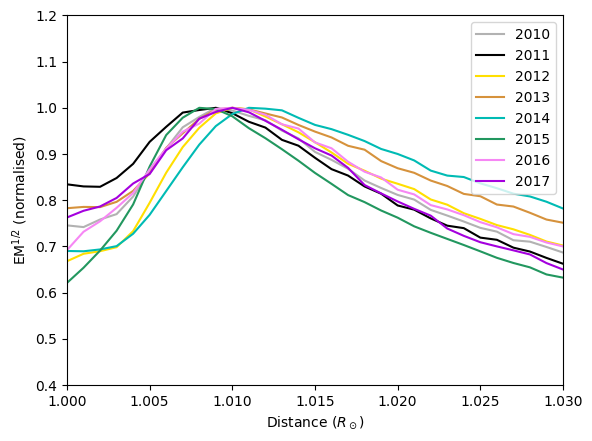

In [ ]:
plt.plot(rad_bins[:-1], ne_avg_2010/np.nanmax(ne_avg_2010), label='2010', color='#B2B2B2')
plt.plot(rad_bins[:-1], ne_avg_2011/np.nanmax(ne_avg_2011), label='2011', color='black' )
plt.plot(rad_bins[:-1], ne_avg_2012/np.nanmax(ne_avg_2012), label='2012', color='#FFDF00')
plt.plot(rad_bins[:-1], ne_avg_2013/np.nanmax(ne_avg_2013), label='2013', color='#D6923C')
plt.plot(rad_bins[:-1], ne_avg_2014/np.nanmax(ne_avg_2014), label='2014', color='#00BBB4')
plt.plot(rad_bins[:-1], ne_avg_2015/np.nanmax(ne_avg_2015), label='2015', color='#22975F')
plt.plot(rad_bins[:-1], ne_avg_2016/np.nanmax(ne_avg_2016), label='2016', color='#F687F4')
plt.plot(rad_bins[:-1], ne_avg_2017/np.nanmax(ne_avg_2017), label='2017', color='#A400DE')

plt.ylabel('EM$^{1/2}$ (normalised)')
plt.xlabel('Distance ($R_\odot$)')
plt.xlim(1,1.03)
plt.ylim(0.4,1.2)
plt.legend(loc=1)
plt.savefig('/content/drive/MyDrive/sdo_cor_hole_data/dens_cor_hole_norm.png', dpi=300)

40373297000000.0

(0.0, 3.0)

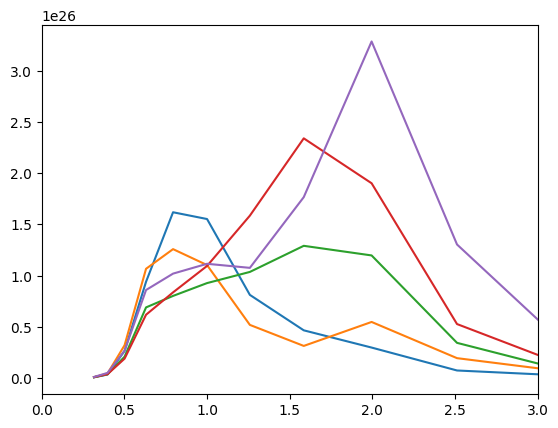

In [ ]:
log_Te = np.linspace(5.5,7.2,18)
plt.plot(10**log_Te/1e6, np.mean(em_avg_2010[40], axis=1)[0])
plt.plot(10**log_Te/1e6, np.mean(em_avg_2011[40], axis=1)[0])
plt.plot(10**log_Te/1e6, np.mean(em_avg_2012[40], axis=1)[0])
plt.plot(10**log_Te/1e6, np.mean(em_avg_2013[40], axis=1)[0])
plt.plot(10**log_Te/1e6, np.mean(em_avg_2014[40], axis=1)[0])

plt.xlim(0,3)

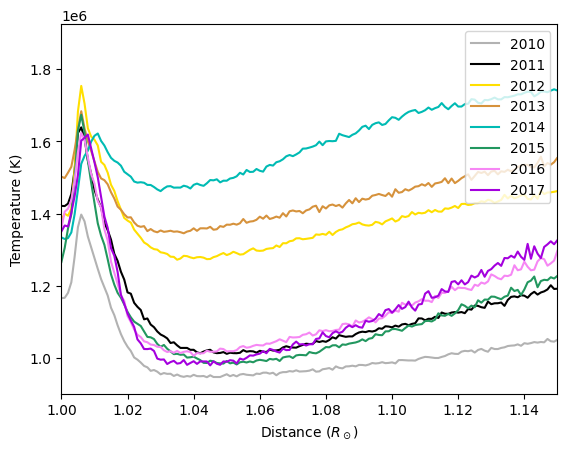

In [32]:
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2010), label='2010', color='#B2B2B2')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2011), label='2011', color='black' )
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2012), label='2012', color='#FFDF00')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2013), label='2013', color='#D6923C')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2014), label='2014', color='#00BBB4')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2015), label='2015', color='#22975F')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2016), label='2016', color='#F687F4')
plt.plot(rad_bins[:-1], 10**np.array(t_avg_2017), label='2017', color='#A400DE')

plt.ylabel('Temperature (K)')
plt.xlabel('Distance ($R_\odot$)')
plt.xlim(1.0, 1.15)
plt.legend(loc=1)

plt.savefig('/content/drive/MyDrive/sdo_cor_hole_data/temp_cor_hole.png', dpi=300)

In [34]:
rad_bins[20]

1.0199999999999978

In [37]:
print(ne_avg_2010[20])
print(ne_avg_2011[20])
print(ne_avg_2012[20])
print(ne_avg_2013[20])
print(ne_avg_2014[20])
print(ne_avg_2015[20])
print(ne_avg_2016[20])
print(ne_avg_2017[20])

32622172000000.0
32458580000000.0
35119134000000.0
39791454000000.0
42975967000000.0
36220785000000.0
30200597000000.0
28474470000000.0


In [32]:
print(ne_std_2010[20])
print(ne_std_2011[20])
print(ne_std_2012[20])
print(ne_std_2013[20])
print(ne_std_2014[20])
print(ne_std_2015[20])
print(ne_std_2016[20])
print(ne_std_2017[20])

103294227240.5949
142123217595.493
98789012195.58685
226089092900.7999
172862760932.53387
130825707489.47319
101065985299.95044
102161373832.61546


In [38]:
print(10**t_avg_2010[20])
print(10**t_avg_2011[20])
print(10**t_avg_2012[20])
print(10**t_avg_2013[20])
print(10**t_avg_2014[20])
print(10**t_avg_2015[20])
print(10**t_avg_2016[20])
print(10**t_avg_2017[20])

1030929.3247213814
1181486.3359101813
1380452.0440835282
1389033.0941986658
1508843.4444195752
1127426.5571541784
1116003.6011796403
1123043.1479314556


In [ ]:
def integrand(x, hpr, dh):
    r_sun_cm = 695658.
    return np.exp(-2*r_sun_cm*(np.sqrt((hpr/r_sun_cm)**2+(x)**2)-1)/(dh/1e5))

quad(integrand, -np.inf, np.inf, args=(695658, 2.*4.7e9))

(0.667717412043797, 1.0497032672138618e-09)

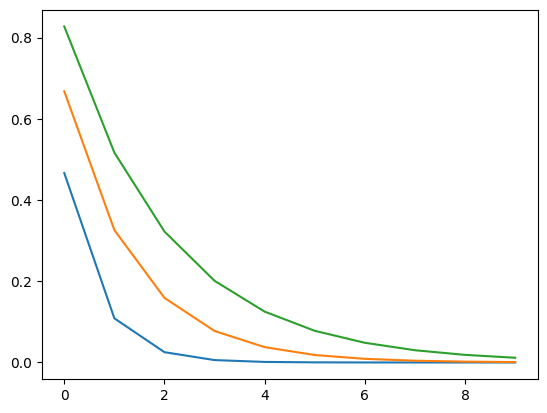

In [ ]:
te_1mk = [quad(integrand, -np.inf, np.inf, args=(695658*1e5*i, 1.*4.7e9))[0] for i in np.arange(1,1.5,0.05)]
te_2mk = [quad(integrand, -np.inf, np.inf, args=(695658*1e5*i, 2.*4.7e9))[0] for i in np.arange(1,1.5,0.05)]
te_3mk = [quad(integrand, -np.inf, np.inf, args=(695658*1e5*i, 3.*4.7e9))[0] for i in np.arange(1,1.5,0.05)]

plt.plot(te_1mk)
plt.plot(te_2mk)
plt.plot(te_3mk)

In [ ]:
index['r']

[SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -64 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                 4096                                                  
 NAXIS2  =                 4096                                                  
 BLD_VERS= 'V8R4X   '                                                            
 LVL_NUM =                  1.5                                                  
 T_REC   = '2014-05-01T01:00:15Z'                                                
 TRECSTEP=                  1.0                                                  
 TRECEPOC= '1977.01.01_00:00:00_TAI'                                             
 TRECROUN=                    1                                                  
 ORIGIN  = 'SDO/JSOC-SDP'                                                        
 DATE    = '2014